In [1]:
%load_ext autoreload
%autoreload 2
import multibind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../annotations'
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import seaborn as sns
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/johanna/anaconda3/envs/multibind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [26]:
matlab_path = os.path.join(bd.constants.ANNOTATIONS_DIRECTORY, 'pbm', 'affreg', 'PbmDataHom6_norm.mat')
mat = scipy.io.loadmat(matlab_path)
data = mat['PbmData'][0]
seqs_dna =  data[0][5]
seqs_dna = [s[0][0] for s in seqs_dna]
# load the MSA sequences, one hot encoded
df, signal = bd.datasets.PBM.pbm_homeo_affreg()
# x, y = pickle.load(open('../../data/example_homeo_PbmData.pkl', 'rb'))
x, y = pickle.load(open('../annotations/pbm/example_homeo_PbmData.pkl', 'rb'))

In [27]:
# build a small subsample
x = x[1:6]
seqs_dna = seqs_dna[1:101]
signal = signal[1:6, 1:101]

In [28]:
# shift signal by adding a constant s.t. no negative values are included
signal -= np.min(signal)

In [29]:
# Set up the dataset
df = pd.DataFrame(signal.T)
df['seq'] = seqs_dna
df.index = df['seq']
del df['seq']

dataset = mb.datasets.ResiduePBMDataset(df, x)
train = tdata.DataLoader(dataset=dataset, batch_size=128, shuffle=True)

# Set up the model
model = mb.models.ProteinDNABinding(0, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()    # mean-squared error for regression

In [30]:
mb.tl.train_network(model, train, device, optimizer, criterion, exp_max=-1, log_each=1, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 15 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch:  2, Loss: 11371.977051 , best epoch: 0 secs per epoch: 0.076 s
Epoch:  3, Loss: 11278.316162 , best epoch: 1 secs per epoch: 0.056 s
Epoch:  4, Loss: 11186.895508 , best epoch: 2 secs per epoch: 0.049 s
Epoch:  5, Loss: 11099.572998 , best epoch: 3 secs per epoch: 0.046 s
Epoch:  6, Loss: 11009.381836 , best epoch: 4 secs per epoch: 0.045 s
Epoch:  7, Loss: 10920.081299 , best epoch: 5 secs per epoch: 0.044 s
Epoch:  8, Loss: 10833.426758 , best epoch: 6 secs per epoch: 0.043 s
Epoch:  9, Loss: 10746.718506 , best epoch: 7 secs per epoch: 0.042 s
Epoch: 10, Loss: 10662.411621 , best epoch: 8 secs per epoch: 0.042 s
Epoch: 11, Loss: 10576.208252 , best epoch: 9 secs per epoch: 0.041 s
Epoch: 12, Loss: 10493.304932 , best epoch: 10 secs per epoch: 0.041 s
Epoch: 13, Loss: 10410.679932 , best epoch: 11 secs per epoch: 0

In [31]:
# Much more epochs (will most likely lead to overfitting)
mb.tl.train_network(model, train, device, optimizer, criterion, num_epochs=5000, exp_max=-1, log_each=200, verbose=2)

optimizing using <class 'torch.optim.adam.Adam'> and <class 'torch.nn.modules.loss.MSELoss'> n_epochs 5000 early_stopping -1
lr= 0.001, weight_decay= 0, dir weight= 0
Epoch: 201, Loss: 3182.877319 , best epoch: 199 secs per epoch: 0.037 s
Epoch: 401, Loss: 1477.199280 , best epoch: 399 secs per epoch: 0.036 s
Epoch: 601, Loss: 805.272079 , best epoch: 599 secs per epoch: 0.036 s
Epoch: 801, Loss: 475.836967 , best epoch: 799 secs per epoch: 0.036 s
Epoch: 1001, Loss: 293.902077 , best epoch: 999 secs per epoch: 0.036 s
Epoch: 1201, Loss: 185.914558 , best epoch: 1199 secs per epoch: 0.036 s
Epoch: 1401, Loss: 119.073900 , best epoch: 1399 secs per epoch: 0.036 s
Epoch: 1601, Loss: 76.673407 , best epoch: 1599 secs per epoch: 0.036 s
Epoch: 1801, Loss: 49.303323 , best epoch: 1799 secs per epoch: 0.036 s
Epoch: 2001, Loss: 31.579000 , best epoch: 1999 secs per epoch: 0.036 s
Epoch: 2201, Loss: 20.061563 , best epoch: 2199 secs per epoch: 0.036 s
Epoch: 2401, Loss: 12.624782 , best epoch

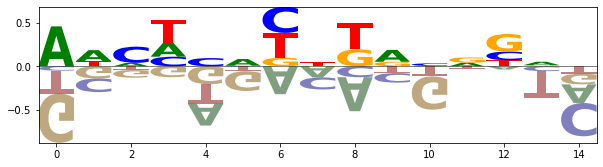

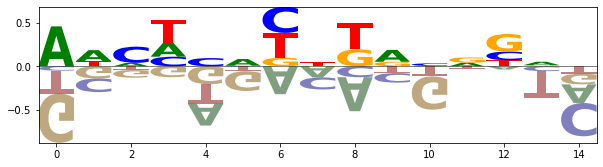

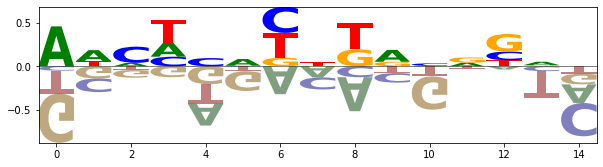

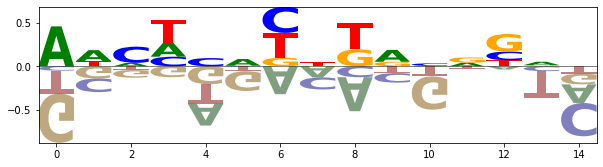

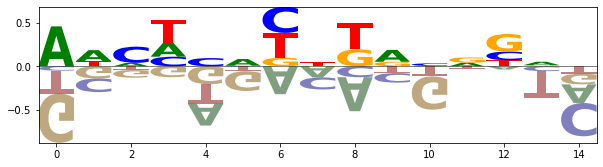

In [32]:
bm_pred = model.get_predicted_bm(torch.tensor(np.stack(x)))
bm_pred = bm_pred.cpu().detach().numpy()
bm_pred.shape
for i in range(0, bm_pred.shape[0]):
    weights = bm_pred[i]
    weights = pd.DataFrame(weights)
    weights.index = "A", "C", "G", "T"
    crp_logo = logomaker.Logo(weights.T, shade_below=0.5, fade_below=0.5)